In [ ]:
#import all the necessary modules
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV # For model selection
from sklearn.model_selection import ShuffleSplit

In [ ]:
def get_data(file_location):
    f_loc = file_location
    h_claims = pd.read_csv(f_loc)
    return (h_claims)

<b>DATA PROCESSING<b/>
    

In [ ]:
"""
returns a dataframe with only the chosen columns and all the types int64 changed to float64
"""
def prep_data(file_data):
    
    hc_relcols = file_data.drop(['Row_ID', 'Household_ID'], axis=1) # these rows are not relevant to the prediction model
    
    hc_relcols = hc_relcols.drop(['Cat2','Cat4','Cat5','Cat7','OrdCat'], axis=1) # these columns have been removed to reduce the vector space. These specifically were chosen because they have alot of missing data 
    
    hc_relcols = hc_relcols.drop(['Var2','Var3','Var4','Var8','NVVar2', 'NVVar3', 'NVVar4'], axis=1) # these columns were dropped to reduce the vector space and becasue they were not relevant to the prediction
    
    for col in ['Vehicle', 'Calendar_Year', 'Model_Year']:  #changing all the ints to floats
        hc_relcols[col] = hc_relcols[col].astype('float64')
    
    hc_relcols.dropna() # drop the rows with missing data
    
    all_cols = list(hc_relcols.columns) #finding the mode of each column to replace missing values in the data
    mode_list = []

    for i in range(len(all_cols)):
        each_col = str(all_cols[i])
        mode_list.append(hc_relcols[each_col].mode()[0])

    for i in range(hc_relcols.shape[1]): #replace '?' with mode
        if(type(hc_relcols.iloc[1,i]) is str):
            for c in range(hc_relcols.shape[0]):
                if ((hc_relcols.iloc[c,i]) == '?'):
                    hc_relcols.iloc[c,i] = mode_list[i]

    return (hc_relcols)

In [ ]:
def trans_cols():

    ftrs_cat_slctd = ['Blind_Make','Blind_Model','Blind_Submodel','Cat1','Cat3','Cat6','Cat8','Cat9','Cat10','NVCat',]

    ftrs_flt_slctd = ['Vehicle','Calendar_Year','Model_Year','Var1','Var5','Var6','Var7','NVVar1']


    full_transform = ColumnTransformer([
        ("num", StandardScaler(), ftrs_flt_slctd),
        ("cat", OneHotEncoder(handle_unknown='ignore'), ftrs_cat_slctd),
    ])
    
    return (full_transform)

In [ ]:
#transformation with standardization
def ns_trans_cols():
    
    ftrs_cat_slctd = ['Blind_Make','Blind_Model','Blind_Submodel','Cat1','Cat3','Cat6','Cat8','Cat9','Cat10','NVCat',]

    full_transform = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown='ignore'), ftrs_cat_slctd),
    ])
    return (full_transform)

In [ ]:
"""
Data contained more zero labels than none zero labels. To prevent incorrect training an equal number of zero and non-zero 
data points were selected for training
"""

def bal_set(dt_set):
    hc_train_set = dt_set
   
    subset_zeros = hc_train_set[hc_train_set.Claim_Amount == 0]  #choose a equal number of zero and none zero data points

    subset_not_zeros = hc_train_set[hc_train_set.Claim_Amount > 0]
    
    equal_subset_zeros = subset_zeros[0:7662]

    balanced_hc_train_set = pd.concat([equal_subset_zeros, subset_not_zeros], ignore_index=True)
    
    return (balanced_hc_train_set)

<b>PERFORMANCE USING A SINGLE MODEL<b/>

In [ ]:
"""
Split the train data into train and validation
"""
def prt_set(dt_set):
    balanced_hc_train_set = dt_set
    
    
    hc_subsettrain_set, hc_subsetval_set = train_test_split(balanced_hc_train_set, test_size=0.15, random_state=42)
    
    hc_subsettrain_set_ftrs = hc_subsettrain_set.drop('Claim_Amount', axis=1) 
    hc_subsettrain_set_lbls = hc_subsettrain_set['Claim_Amount']

    hc_subsetval_set_ftrs = hc_subsetval_set.drop('Claim_Amount', axis=1)
    hc_subsetval_set_lbls = hc_subsetval_set['Claim_Amount']
    
    full_transform = trans_cols()
    
    hc_train_set_fts_trfmd = full_transform.fit_transform(hc_subsettrain_set_ftrs)
    hc_val_set_fts_trfmd = full_transform.transform(hc_subsetval_set_ftrs)
        
    return (hc_train_set_fts_trfmd, hc_subsettrain_set_lbls, hc_val_set_fts_trfmd, hc_subsetval_set_lbls)

<b>a) Linear regression<b/>

In [ ]:
"""
Performs a gradient search for determining hyprparameters and then carries out a linear regression
"""
def gr_search_lin(train_ftrs, train_lbls, val_ftrs, val_lbls):
    tf = train_ftrs
    tl = train_lbls
    vf = val_ftrs
    vl = val_lbls


    from sklearn.linear_model import LinearRegression
    lin_reg = LinearRegression()

    par_fit_intercept = np.array([True, False])
    param_normalize = np.array([True, False])
    param_copy = np.array([True, False])
    param_njobs = [3, 6, 9, 12]
    
    param_grid = dict(fit_intercept=par_fit_intercept, normalize=param_normalize, copy_X=param_copy, n_jobs=param_njobs)
    cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    grid = GridSearchCV(lin_reg, param_grid=param_grid, cv=cv,)
    grid.fit(train_ftrs, train_lbls)
    
    params = grid.best_params_
    print(params)

    lin_reg = LinearRegression(params)
    lin_reg.fit(tf, tl)
    
    hc_predictions_linear = lin_reg.predict(vf)

    error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_linear))
    error_mod_lin
    
    return (grid.best_params_, error_mod_lin)

In [ ]:
"""
Obtain hyperparameters for Linear Regression
"""
def hp_linear_regression(test_set):
    chosen_data = prep_data(test_set)
    balanced_data_set = bal_set(chosen_data)
    td,tl,vd,vl = prt_set(balanced_data_set)
    lin_reg = gr_search_lin(td,tl,vd,vl)
    
    return (lin_reg) 

In [ ]:
test_set = get_data('./train.csv')
l_pred = hp_linear_regression(test_set)

print(l_pred)

<b>b) Ridge regression <b/>

In [ ]:
"""
Performs Gradient Search and then carries out a Ridge regression prediction
"""
def gr_search_ridge(train_ftrs, train_lbls, val_ftrs, val_lbls):

    tf = train_ftrs
    tl = train_lbls
    vf = val_ftrs
    vl = val_lbls
    
    rig_reg = Ridge()

    param_alpha = ([1,0.1,0.01])
    par_fit_intercept = np.array([True, False])
    param_normalize = np.array([True, False])
    param_copy = np.array([True, False])
    param_maxiter = [1000, 2000]
    param_tol = [0.001, 0.005]
    param_solver = ['sag']
    param_rstate = [None, 3, 5]
    
    param_grid = dict(alpha = param_alpha, fit_intercept=par_fit_intercept, normalize=param_normalize, copy_X=param_copy, max_iter=param_maxiter, tol=param_tol, solver=param_solver, random_state=param_rstate)
    cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    grid = GridSearchCV(rig_reg, param_grid=param_grid, cv=cv,)
    grid.fit(train_ftrs, train_lbls)
    
    params = grid.best_params_

    rig_reg = Ridge()
    rig_reg.fit(tf, tl)
    
    hc_predictions_ridge = rig_reg.predict(vf)

    error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_ridge))
    error_mod_lin
    
    return (grid.best_params_, error_mod_lin)

In [ ]:
def hp_ridge_regression(test_set):
    chosen_data = prep_data(test_set)
    balanced_data_set = bal_set(chosen_data)
    td,tl,vd,vl = prt_set(balanced_data_set)
    ridge_reg = gr_search_ridge(td,tl,vd,vl)
    
    return(ridge_reg)


In [ ]:
test_set = get_data('./train.csv')

ridge_prdcts = hp_ridge_regression(test_set)
print(ridge_prdcts)

<b>c) Random forests for regression<b/>

In [ ]:
"""
Performs a Gradient Search for hyper parematers and then performs a Random Forest Regression prediction
"""
def gr_search_rf(train_ftrs, train_lbls, val_ftrs, val_lbls):

    import numpy as np
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import GridSearchCV # For model selection

    tf = train_ftrs
    tl = train_lbls
    vf = val_ftrs
    vl = val_lbls

    from sklearn.ensemble import RandomForestRegressor
    rtree_reg = RandomForestRegressor()

    p_nest = np.array([10, 100]) 
    p_crit = criterion=['mse', 'mae'] 
    p_mdepth = [1, 5]
    p_msamples =[2, 4] 
    p_msleaf = [1, 2] 
    p_mwfleaf = [0.0, 0.5]
    p_mfeat = ['auto', 'sqrt'] 
    p_mlnodes = [2, 4] 
    p_midec = [0.0, 0.5] 
    p_misplit = [1, 3] 
    p_bootstrap = [True, False] 
    p_oscore= [False, True] 
    p_njobs= [2, 5] 
    p_rstate = [5, 10] 
    p_verbose= [0, 1, 5] 
    p_wstart = [False, True] 
    p_calpha = [0.0] 
    p_msamples = [2, 5]
    
    param_grid = dict(n_estimators=p_nest, criterion=p_crit, max_depth=p_mdepth, min_samples_split=p_msamples, \
                      min_samples_leaf=p_msleaf, min_weight_fraction_leaf=p_mwfleaf, max_features=p_mfeat, \
                      max_leaf_nodes=p_mlnodes, min_impurity_decrease=p_midec, min_impurity_split=p_misplit, \
                      bootstrap=p_bootstrap, oob_score=p_oscore, n_jobs=p_njobs, random_state=p_rstate, \
                      verbose=p_verbose, warm_start=p_wstart)
    
    cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    grid = GridSearchCV(rtree_reg, param_grid=param_grid, cv=cv,)
    grid.fit(train_ftrs, train_lbls)
    
    params = grid.best_params_

    rtree_reg = RandomForestRegressor(params)
    rtree_reg.fit(tf, tl)
    
    hc_predictions_rtree = rtree_reg.predict(vf)

    error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_rtree))
    error_mod_lin
    
    return (grid.best_params_, error_mod_lin)

In [ ]:
def hp_random_forests(test_set):
    chosen_data = prep_data(test_set)
    balanced_data_set = bal_set(chosen_data)
    td,tl,vd,vl = prt_set(balanced_data_set)
    
    td_s = td[0:50] #subset of data to save on time for gradeint search
    tl_s = tl[0:50]
    vd_s = vd[0:25]
    vl_s = vl[0:25]
    
    rtree_reg = gr_search_rf(td_s,tl_s,vd_s,vl_s)
    
    return(rtree_reg)

In [ ]:
#without gradient boosting
from sklearn.ensemble import RandomForestRegressor

chosen_data = prep_data(test_set)
balanced_data_set = bal_set(chosen_data)
td,tl,vd,vl = prt_set(balanced_data_set)

rtree_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, max_features='auto', \
                                    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,\
                                    min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20,\
                                    n_jobs=None,oob_score=False, random_state=0, verbose=0, warm_start=False)

rtree_reg.fit(td, tl ,sample_weight=None)
    
hc_predictions_rtree = rtree_reg.predict(vd)

error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_rtree))
error_mod_lin

<b>d) Gradient tree boosting for regression <b/>

In [ ]:
"""
Performs a Gradient Search for hyper parematers and then performs a Gradient Tree Boosting prediction
"""
def gr_search_gtb(train_ftrs, train_lbls, val_ftrs, val_lbls):

    import numpy as np
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import GridSearchCV # For model selection

    tf = train_ftrs
    tl = train_lbls
    vf = val_ftrs
    vl = val_lbls

    from sklearn.ensemble import GradientBoostingRegressor
    gradtree_reg = GradientBoostingRegressor()

    p_lrate = [0.1, 0.2] 
    p_nest= [200, 500] 
    p_ssa = [0.5, 1] 
    p_crit=['friedman_mse', 'mse', 'mae'] 
    p_mss=[2, 5] 
    p_msl = [2, 5] 
    p_mwfl = [0.25, 0.5] 
    p_md = [3, 10] 
    p_mid = [0.5, 1.0] 
    p_init = [None, 'zero'] 
    p_rs = [2, 5] 
    p_mf = ['auto', 'sqrt'] 
    p_ver = [0, 2, 5]
    p_mln = [5, 10] 
    p_ws = [False, True] 
    p_vf = [0.1, 0.2, 0.5] 
    p_nnc = [1, 5] 
    p_tol = [0.0001] 
    
    param_grid = dict(learning_rate=p_lrate, n_estimators=p_nest, subsample=p_ssa, criterion=p_crit,\
                      min_samples_split=p_mss, min_samples_leaf=p_msl, min_weight_fraction_leaf=p_mwfl,\
                      max_depth=p_md, min_impurity_decrease=p_mid, init=p_init, random_state=p_rs,\
                      max_features=p_mf, verbose=p_ver, max_leaf_nodes=p_mln, warm_start=p_ws)
    
    cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    grid = GridSearchCV(gradtree_reg, param_grid=param_grid, cv=cv,)
    grid.fit(train_ftrs, train_lbls)
    
    params = grid.best_params_
    
    gradtree_reg = GradientBoostingRegressor(params)
    gradtree_reg.fit(tf, tl)
    
    hc_predictions_gradtree = rig_reg.predict(vf)

    error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_gradtree))
    error_mod_lin
    
    return (grid.best_params_, error_mod_lin)

In [ ]:
def hp_gradient_tree(test_set):
    chosen_data = prep_data(test_set)
    balanced_data_set = bal_set(chosen_data)
    td,tl,vd,vl = prt_set(balanced_data_set)
    
    td_s = td[0:10] #subset of data to save on time for gradeint search
    tl_s = tl[0:10]
    vd_s = vd[0:2]
    vl_s = vl[0:2]

    gtree_reg = gr_search_gtb(td_s,tl_s,vd_s,vl_s)
    
    return(rtree_reg)

In [ ]:
#without gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

chosen_data = prep_data(test_set)
balanced_data_set = bal_set(chosen_data)
td,tl,vd,vl = prt_set(balanced_data_set)

gradtree_reg = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.1, loss='ls', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=0, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
gradtree_reg.fit(td, tl)
    
hc_predictions_gradtree = gradtree_reg.predict(vd)

error_mod_lin = np.sqrt(mean_squared_error(vl, hc_predictions_gradtree))
error_mod_lin

<b>PERFORMANCE USING A COMBINATION OF TWO MODELS<b/>

You can build a prediction model based on two separate models in tandem (one after the other, see Figure 1). Once again, be careful about the preprocessing step 1. For this step, use the same training and validation sets from step 2.
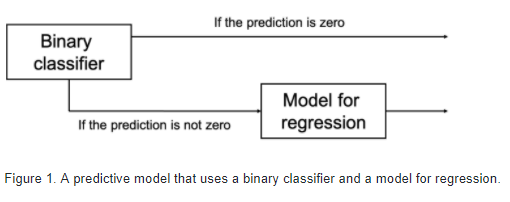

In [ ]:
"""
Helper function used when working with two models
"""

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

def choose_model(name, train_data, train_labels, val_data):
    pred_model = name
    td = train_data
    tl = train_labels
    vd = val_data
    
    if(pred_model == 'Linear'):
        lin_reg = LinearRegression(fit_intercept = False, normalize = True, copy_X = True, n_jobs = 3 )
        lin_reg.fit(td, tl)
        
        predictions = lin_reg.predict(vd)
        
    elif(pred_model == 'Ridge'):
        rig_reg = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
        rig_reg.fit(td, tl)
        
        predictions = rig_reg.predict(vd)

    elif(pred_model == 'Forests'):
        rtree_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None, max_features='auto', \
                                    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,\
                                    min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20,\
                                    n_jobs=None,oob_score=False, random_state=0, verbose=0, warm_start=False)
        rtree_reg.fit(td, tl ,sample_weight=None)
        
        predictions = rtree_reg.predict(vd)

    elif(pred_model == 'Gradient'):
        gradtree_reg = GradientBoostingRegressor( alpha=0.9, criterion='friedman_mse', init=None, learning_rate=0.1, loss='ls', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=0, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
        gradtree_reg.fit(td, tl)
        
        predictions = gradtree_reg.predict(vd)

    return (predictions)

In [ ]:
"""
Carry out prediction using two models
"""

def comb_models(datafr, model1, model2):
    from sklearn.metrics import mean_squared_error
    import numpy as np

    d_set = datafr
    m1 = model1
    m2 = model2
    
    row_in = []
    for i in range(d_set.shape[0]):
        row_in.append(i+1)
        
    bn_values = []
    for i in range(d_set.shape[0]):
        if (d_set.iloc[i,(d_set.shape[1]-1)] == 0):
            bn_values.append(0)
        else:
            bn_values.append(1)


    #insert these two lists into the dataframe
    d_set.insert(d_set.shape[1], 'Row_ind', row_in)
    d_set.insert(d_set.shape[1], 'Bn_val', bn_values)
    
    
    #Split the train data into train and validation
    comb_train_set, comb_val_set = train_test_split(d_set, test_size=0.15, random_state=42)

    ##for first model
    first_model_ftrs = comb_train_set.drop(['Claim_Amount', 'Row_ind', 'Bn_val'],  axis=1) 
    first_model_lbls = comb_train_set['Bn_val']

    first_model_val_ftrs = comb_val_set.drop(['Claim_Amount', 'Row_ind', 'Bn_val'], axis=1) 
    first_model_val_lbls = comb_val_set['Bn_val']

    ##for second model
    second_model_ftrs = comb_train_set[comb_train_set['Bn_val'] == 1]
    second_model_lbls = second_model_ftrs['Claim_Amount']
    second_model_ftrs_drop = second_model_ftrs.drop(['Claim_Amount', 'Row_ind', 'Bn_val'],  axis=1) 

    ##filtered below
    second_model_val_ftrs = comb_val_set.drop(['Bn_val'], axis=1) 

    #transformations
    #transforming the train feature vecotrs
    full_transform = trans_cols()
    second_model_ftrs_trfmd = full_transform.fit_transform(second_model_ftrs_drop)

    #transforming the valdation features

    first_model_ftrs_trfmd = full_transform.fit_transform(first_model_ftrs)
    first_model_val_ftrs_trfmd = full_transform.transform(first_model_val_ftrs)
    
    second_model_ftrs_trfmd = full_transform.fit_transform(second_model_ftrs_drop)

    #First model
    hc_predictions_rtree_com = choose_model(m1, first_model_ftrs_trfmd, first_model_lbls, first_model_val_ftrs_trfmd )

    #check mse for first model alone
    error_mod_comb_first = np.sqrt(mean_squared_error(first_model_val_lbls, hc_predictions_rtree_com))
    #print("MSE",error_mod_comb_first)
    #obtain a list containing index to non zero predictions for both the training data(using the nb_val) and the validation set, 
    #using the predictions from the first part
    
    ftr_list = [] #fltr_list
    col_rid = (second_model_val_ftrs.shape[1] - 1)

    for i in range(hc_predictions_rtree_com.shape[0]):
        if (hc_predictions_rtree_com[i] == 0 ):
            ftr_list.append((second_model_val_ftrs.iloc[i,col_rid]) - 1)

    scnd_set = second_model_val_ftrs.drop(ftr_list)
    
    scnd_set_drpd = scnd_set.drop(['Claim_Amount','Row_ind'], axis=1)

    #transform the validation features and get the labels
    second_model_val_lbls = scnd_set['Claim_Amount']
    second_model_val_ftrs_trfmd = full_transform.transform(scnd_set_drpd)
    
    #second model
    #assessing the performance over the validation set
   
    hc_predictions_linear_com = choose_model(m2, second_model_ftrs_trfmd, second_model_lbls, second_model_val_ftrs_trfmd)
    
    import numpy as np
    total_pred = np.concatenate((hc_predictions_rtree_com, hc_predictions_linear_com))
    total_pred.shape
    
    all_lbls = pd.concat([first_model_val_lbls, second_model_val_lbls])
    all_lbls.shape
    
    #We can now compute the RMSE obtained with this predictive model. We can use the scikit-learn routine for computing the mean squared error and then compute the square root.
    #gradient tree regression
    from sklearn.metrics import mean_squared_error
    import numpy as np
    error_mod_comb = np.sqrt(mean_squared_error(all_lbls, total_pred))
    
    
    return (error_mod_comb)

In [ ]:
"""
Comparison of different combinations of models
"""

test_set = get_data('./train.csv')
t_data = test_set   
rel_t_data = prep_data(test_set)
balanced_hc_train_set = bal_set(rel_t_data)

#fr_lin = comb_models(balanced_hc_train_set, 'Forests', 'Linear' )
#gr_lin = comb_models(balanced_hc_train_set, 'Gradient', 'Linear' )
#fr_rd = comb_models(balanced_hc_train_set, 'Forests', 'Ridge' )
gr_rd = comb_models(balanced_hc_train_set, 'Gradient', 'Ridge' )
print(gr_rd) # fr_lin #gr_lin, fr_rd, gr_rd)

In [ ]:
"""
Run the best combination of the models
"""

def best_predictor(test_data):
    test_set = test_data
    t_data = test_set   
    rel_t_data = prep_data(test_set)
    
    balanced_hc_train_set = bal_set(rel_t_data)

    ttpr = comb_models(balanced_hc_train_set, 'Forests', 'Ridge' )
    return (ttpr)

In [ ]:
test_set = get_data('./train.csv')
bst_performer = best_predictor(test_set)
print("Mean Square Error of the Best Performing Model:",bst_performer)